In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import asin, sqrt
from math import pi

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [14]:
train = pd.read_csv("./datasets/titanic/train.csv")

In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
def chance_to_survive(age):
    pop = train[train.Age.eq(age)]
    surv = pop[pop.Survived.eq(1)]
    prob = len(surv)/(len(pop)+1)
    return "A {}-year old passenger had a chance to survive of {}".format(age, prob)

In [17]:
print(chance_to_survive(47))
print(chance_to_survive(48))

A 47-year old passenger had a chance to survive of 0.1
A 48-year old passenger had a chance to survive of 0.6


In [18]:
# max age of a child
max_child_age = 8

# probability to survive of children
pop_child = train[train.Age.le(max_child_age)]
surv_child = pop_child[pop_child.Survived.eq(1)]
p_child = len(surv_child)/len(pop_child)
p_child

0.6666666666666666

In [19]:
# probability to survive of adults
pop_adult = train[train.Age.gt(max_child_age)]
surv_adult = pop_adult[pop_adult.Survived.eq(1)]
p_adult = len(surv_adult)/len(pop_adult)
p_adult

0.38484848484848483

In [20]:
print("{} children had a chance to survive of {}".format(len(pop_child), round(p_child, 2)))
print("{} adults had a chance to survive of {}".format(len(pop_adult), round(p_adult, 2)))

54 children had a chance to survive of 0.67
660 adults had a chance to survive of 0.38


In [21]:
def prob_to_angle(prob):
    """
    Converts a given P(psi) value into an equivalent theta value.
    """
    return 2*asin(sqrt(prob))

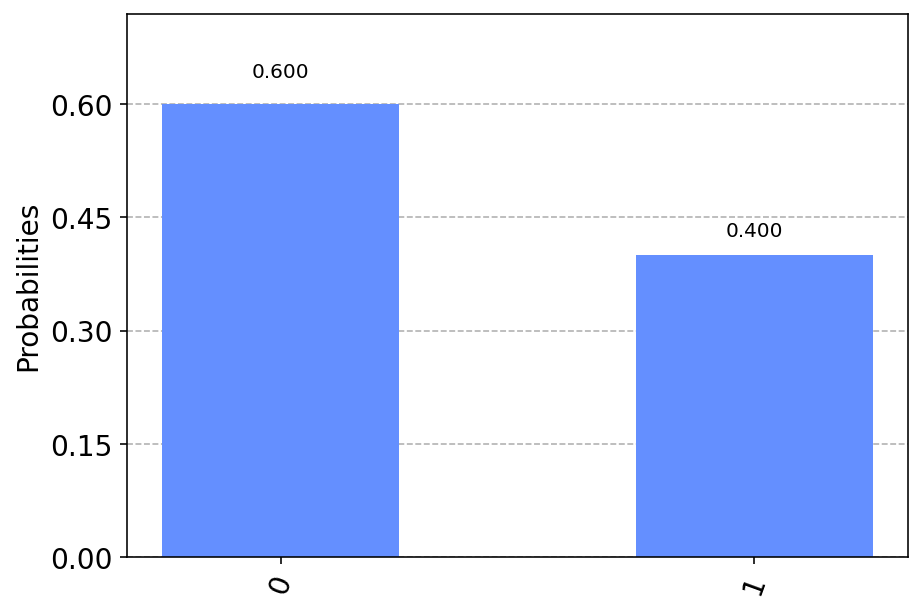

In [22]:
qc = QuantumCircuit(1)

# Set qubit to prior
qc.ry(prob_to_angle(0.4), 0)

# execute the qc
results = execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()
plot_histogram(results)

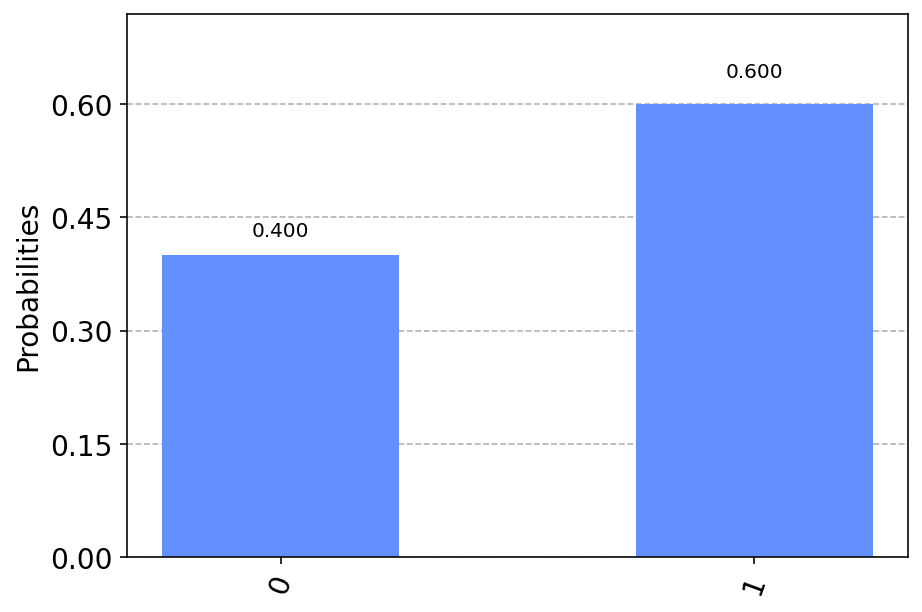

In [23]:
qc = QuantumCircuit(1)

# Set qubit to prior
qc.ry(prob_to_angle(0.4), 0)

# Switch the qubit's value
qc.x(0)

# execute the qc
results = execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()
plot_histogram(results)

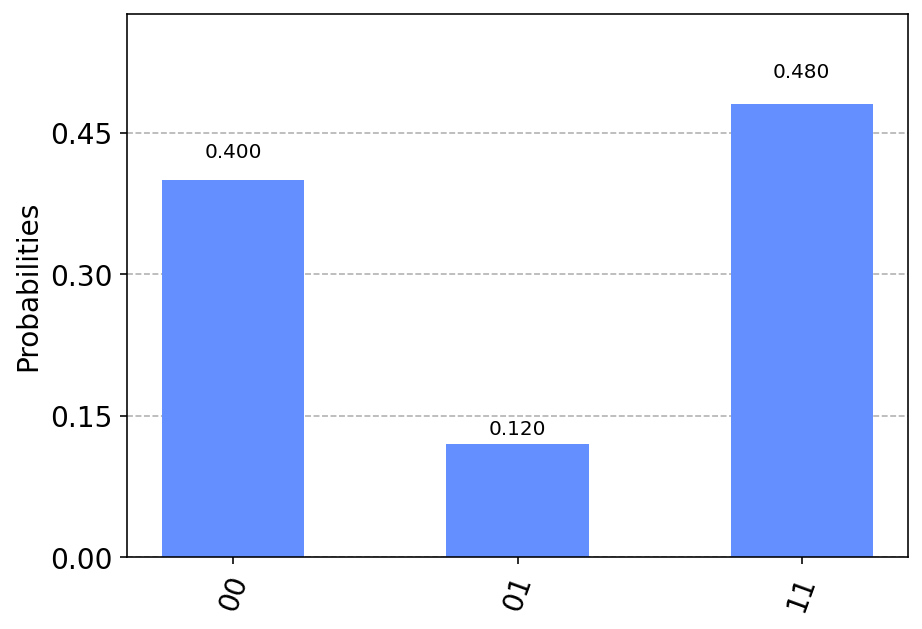

In [24]:
qc = QuantumCircuit(2)

# Set qubit to prior
qc.ry(prob_to_angle(0.4), 0)

# Switch the qubit's value
qc.x(0)

# Calculate the joint probability of NOT-prior and an event
qc.cry(prob_to_angle(0.8), 0,1)

# execute the qc
results = execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()
plot_histogram(results)

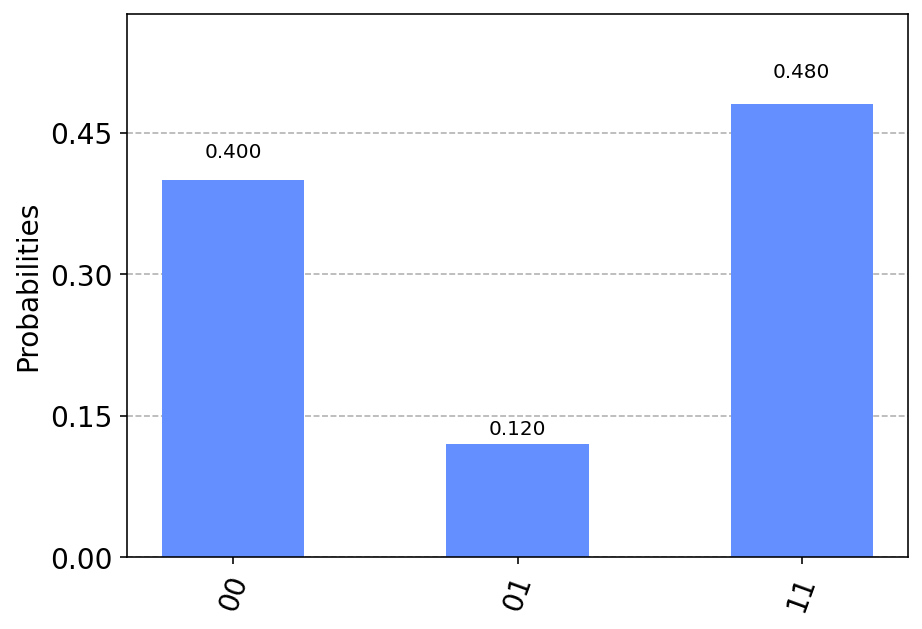

In [25]:
qc = QuantumCircuit(2)

# Set qubit to prior
qc.ry(prob_to_angle(0.4), 0)

# Switch the qubit's value
qc.x(0)

# Apply half of the event's probability
qc.ry(prob_to_angle(0.8)/2, 1)

# entangle qubits 0 and 1
qc.cx(0,1)

# Apply the other half of ev_b
qc.ry(-prob_to_angle(0.8)/2, 1)

# unentganle qubits 0 and 1
qc.cx(0,1)

# execute the qc
results = execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()
plot_histogram(results)

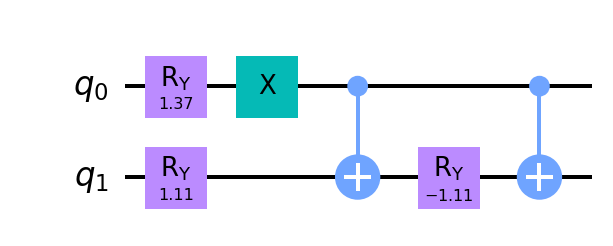

In [26]:
qc.draw('mpl')

In [29]:
theta = pi/2

def ccnot(qc):
    # Apply the first half of the rotatione
    qc.cry(theta, 1,2)

    # This sequence has no effect if both control qubits
    # are in state |1>
    qc.cx(0,1)
    qc.cry(-theta,1,2)
    qc.cx(0,1)

    # Apply the second half of the rotation
    qc.cry(theta, 0,2)

    # execute the qc
    return execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()

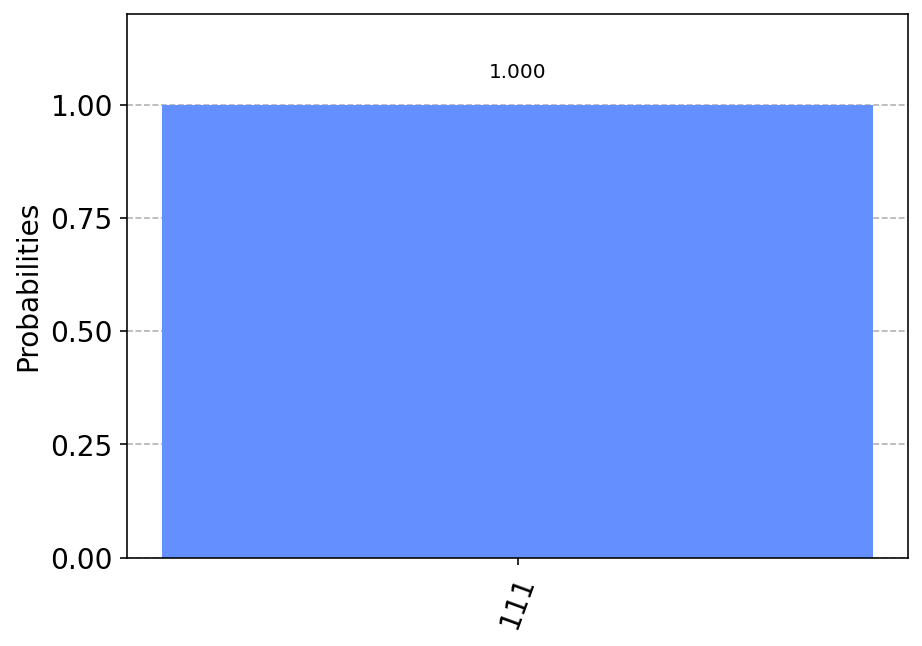

In [30]:
qc = QuantumCircuit(3)

# set both qubits to |1>
qc.x(0)
qc.x(1)

# apply the ccnot-gate and execute the qc
results = ccnot(qc)
plot_histogram(results)

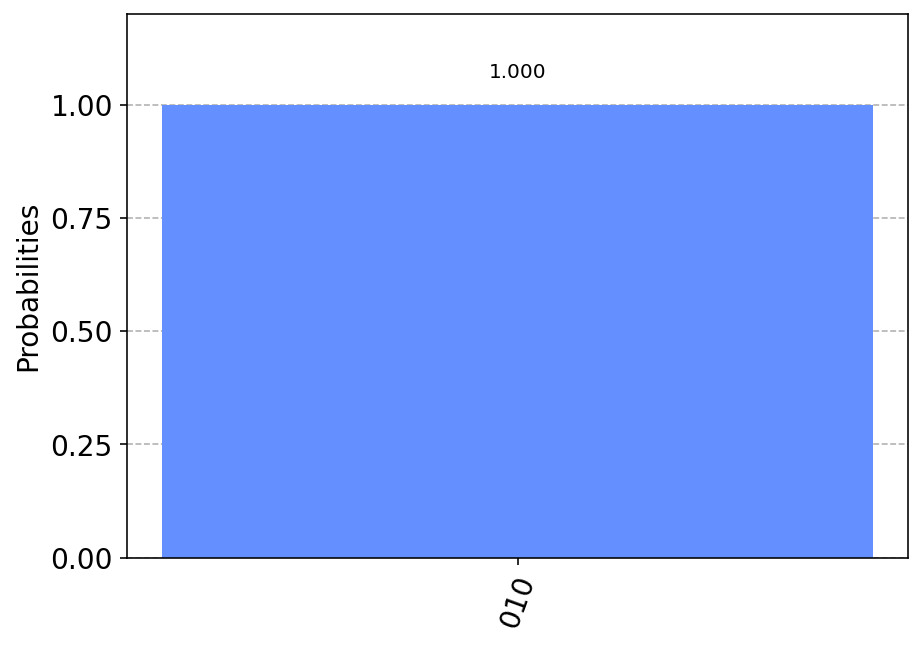

In [31]:
qc = QuantumCircuit(3)

# set only qubit q_1 to |1>
qc.x(1)

# apply the ccnot-gate and execute the qc
results = ccnot(qc)
plot_histogram(results)

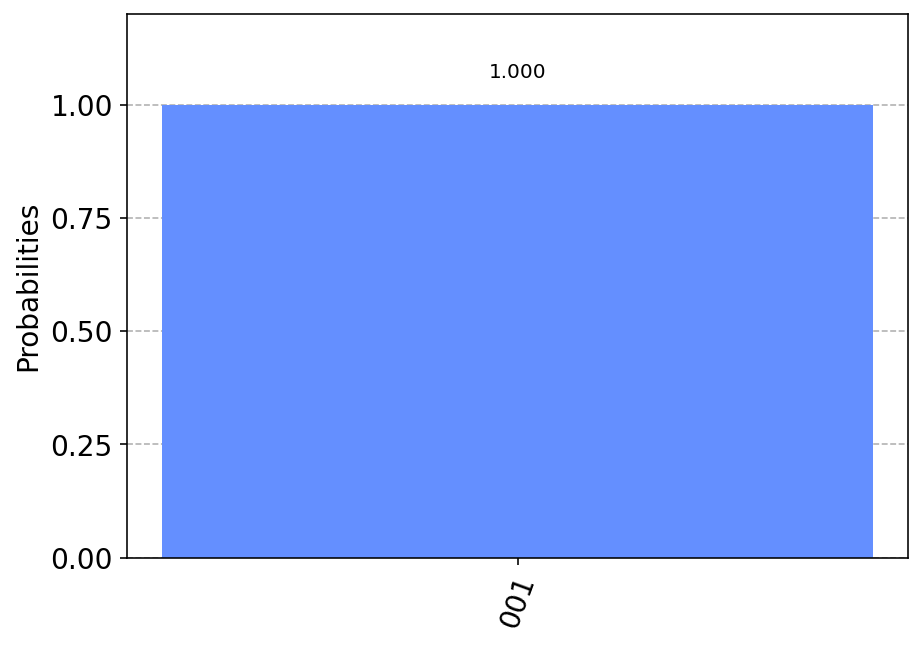

In [36]:
qc = QuantumCircuit(3)

# set only qubit q_0 to |1>
qc.x(0)
qc.barrier()
# apply the ccnot-gate and execute the qc
results = ccnot(qc)
plot_histogram(results)

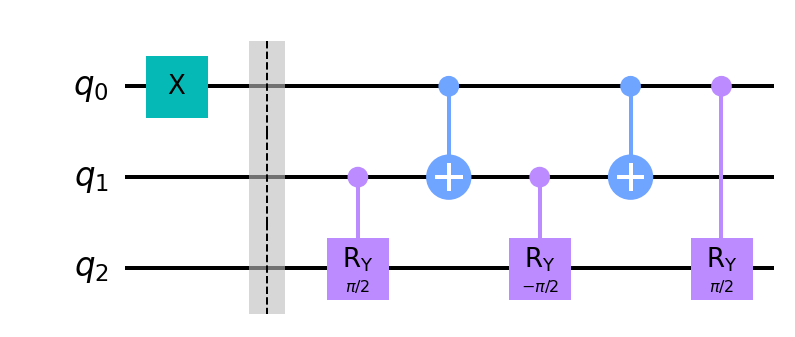

In [35]:
qc.draw('mpl')

### Quantum Bayesian Network

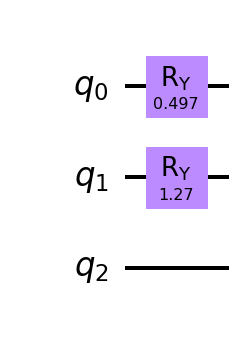

In [39]:
max_child_age = 8

# probability of being a child
population_child = train[train.Age.le(max_child_age)]
p_child = len(population_child)/len(train)

# probability of being female
population_female = train[train.Sex.eq("female")]
p_female = len(population_female)/len(train)

# Initialize the quantum circuit
qc = QuantumCircuit(3)

# Set qubit0 to p_child
qc.ry(prob_to_angle(p_child), 0)

# Set qubit1 to p_female
qc.ry(prob_to_angle(p_female), 1)

qc.draw('mpl')

In [40]:
def ccry(qc, theta, control1, control2, controlled):
    qc.cry(theta/2, control2, controlled)
    qc.cx(control1, control2)
    qc.cry(-theta/2, control2, controlled)
    qc.cx(control1, control2)
    qc.cry(theta/2, control1, controlled)

In [42]:
# female child
population_female = train[train.Sex.eq("female")]
population_f_c = population_female[population_female.Age.le(max_child_age)]
surv_f_c = population_f_c[population_f_c.Survived.eq(1)]
p_surv_f_c = len(surv_f_c)/len(population_f_c)

# female adults
population_f_a = population_female[population_female.Age.gt(max_child_age)]
surv_f_a = population_f_a[population_f_a.Survived.eq(1)]
p_surv_f_a = len(surv_f_a)/len(population_f_a)

# male children
population_male = train[train.Sex.eq("male")]
population_m_c = population_male[population_male.Age.le(max_child_age)]
surv_m_c = population_m_c[population_m_c.Survived.eq(1)]
p_surv_m_c = len(surv_m_c)/len(population_m_c)

# male adults
population_m_a=population_male[population_male.Age.gt(max_child_age)]
surv_m_a=population_m_a[population_m_a.Survived.eq(1)]
p_surv_m_a=len(surv_m_a)/len(population_m_a)

In [45]:
# set state |01> to conditional probability of male adult
qc.x(0)
qc.x(1)
ccry(qc,prob_to_angle(p_surv_m_a),0,1,2)
qc.x(0)
qc.x(1)

# set state |01> to conditional probability of female adults
qc.x(0)
ccry(qc,prob_to_angle(p_surv_m_c),0,1,2)
qc.x(0)

# set state |10> to conditional probability of male children
qc.x(1)
ccry(qc,prob_to_angle(p_surv_f_a),0,1,2)
qc.x(1)

# set state |11> to conditional probability of female children
ccry(qc,prob_to_angle(p_surv_f_c),0,1,2)

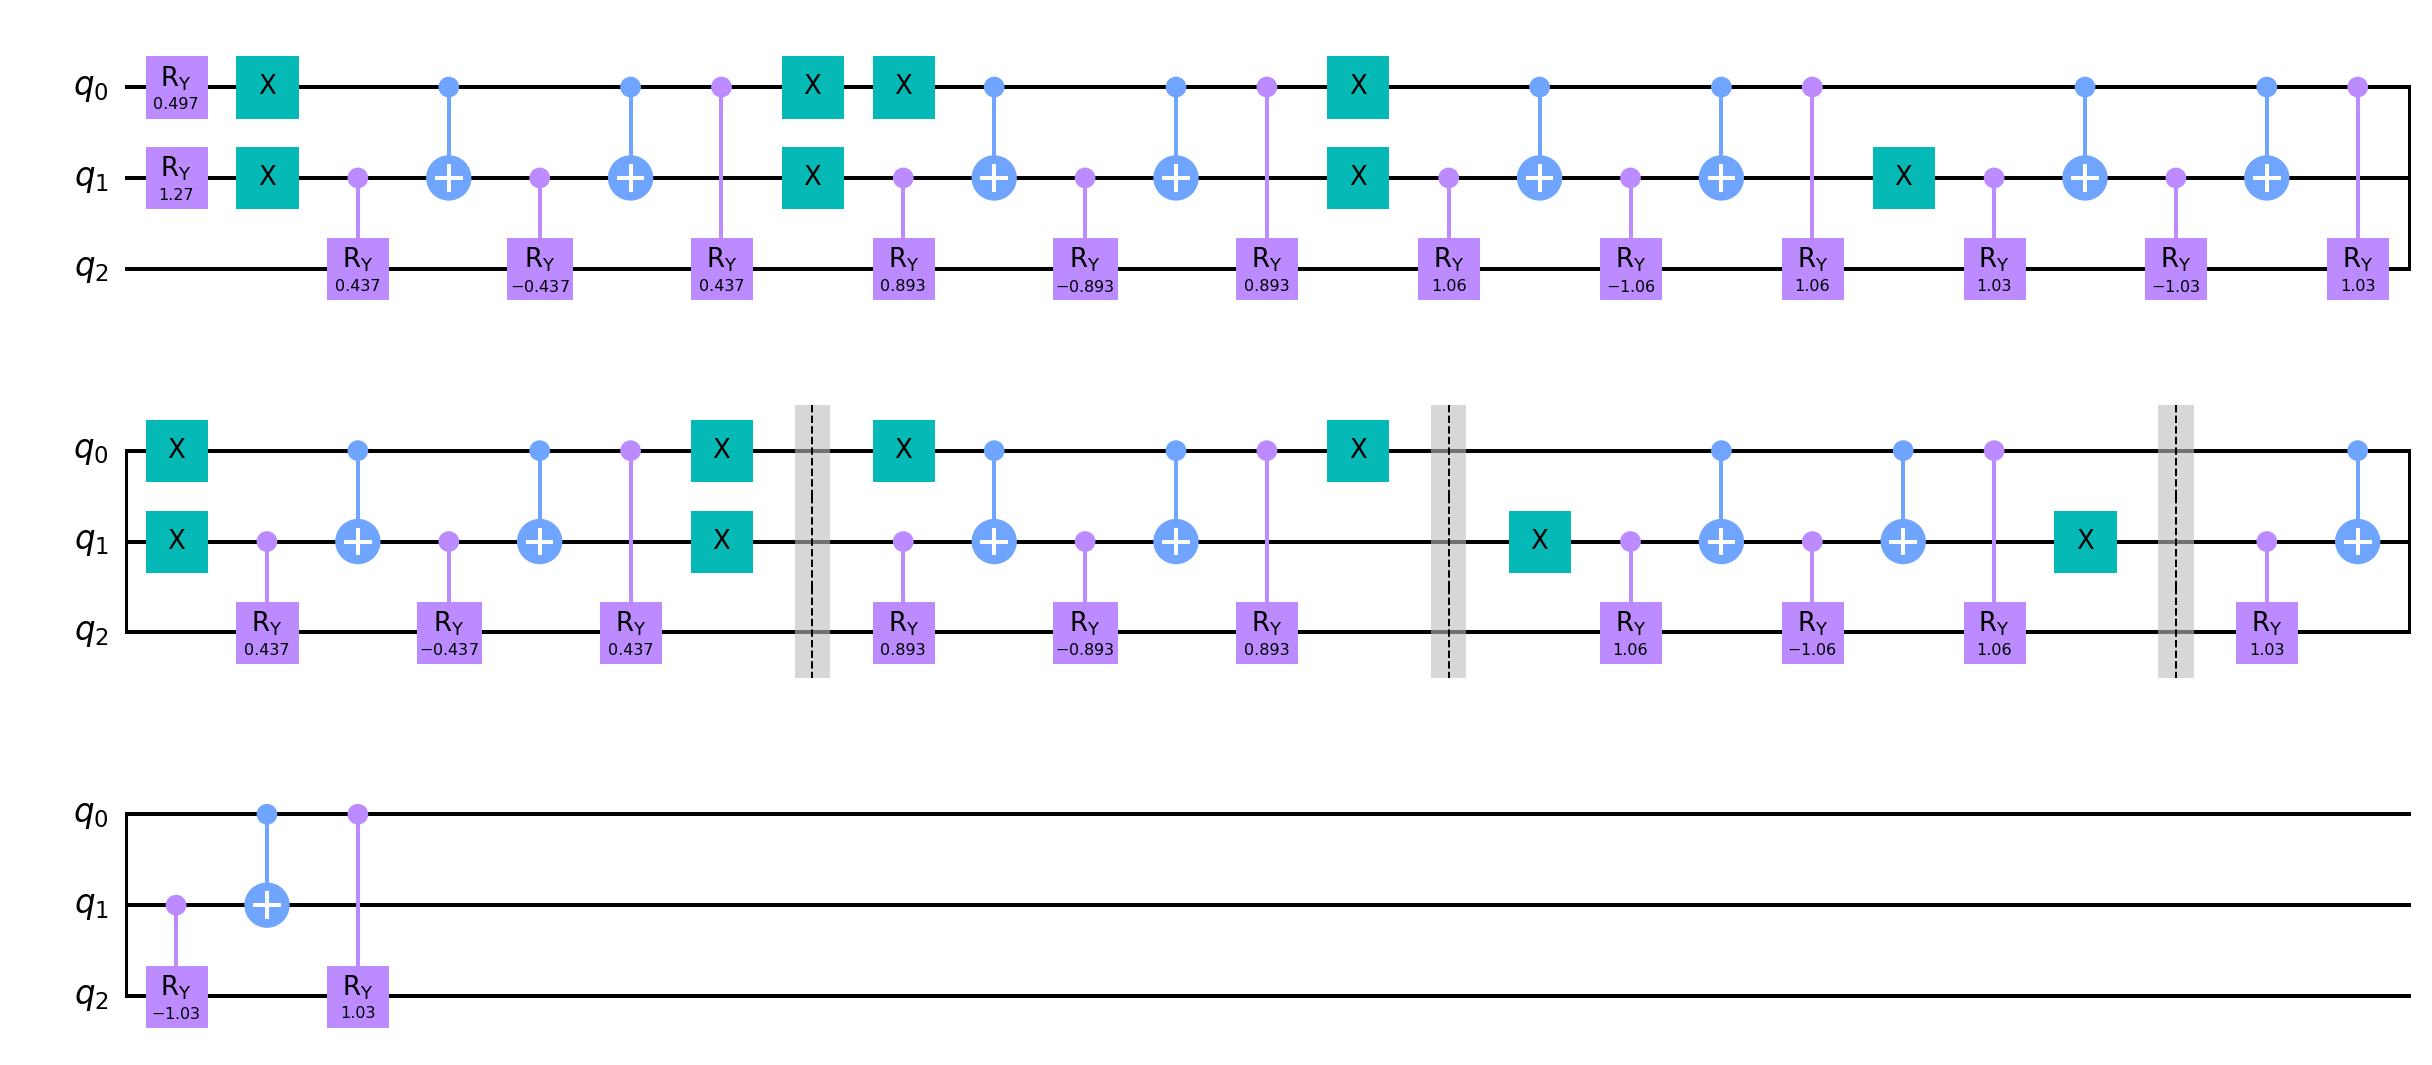

In [46]:
qc.draw('mpl')

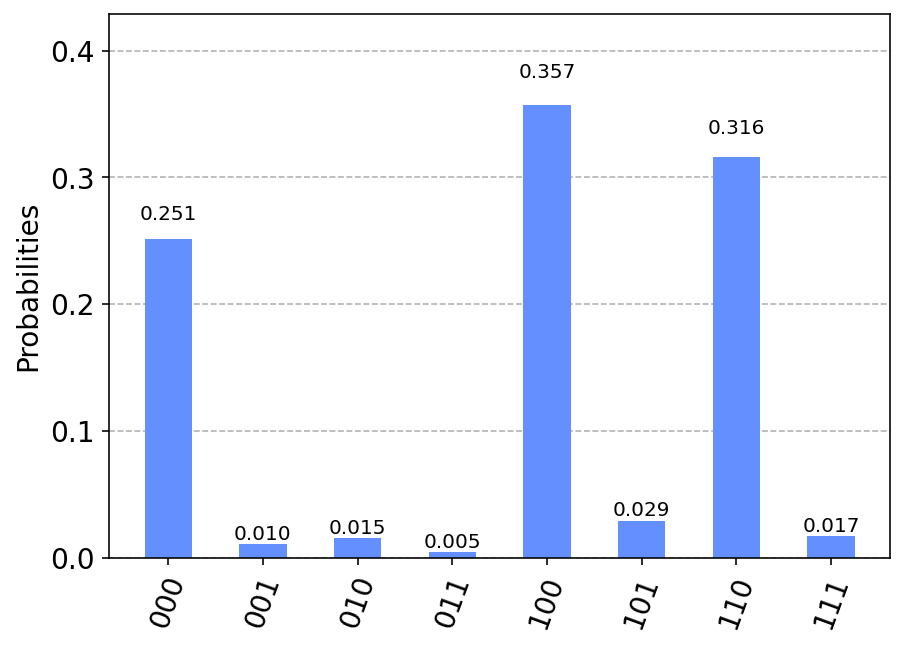

In [47]:
results = execute(qc,Aer.get_backend('statevector_simulator')).result().get_counts()
plot_histogram(results)

In [52]:
qr = QuantumRegister(3)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)

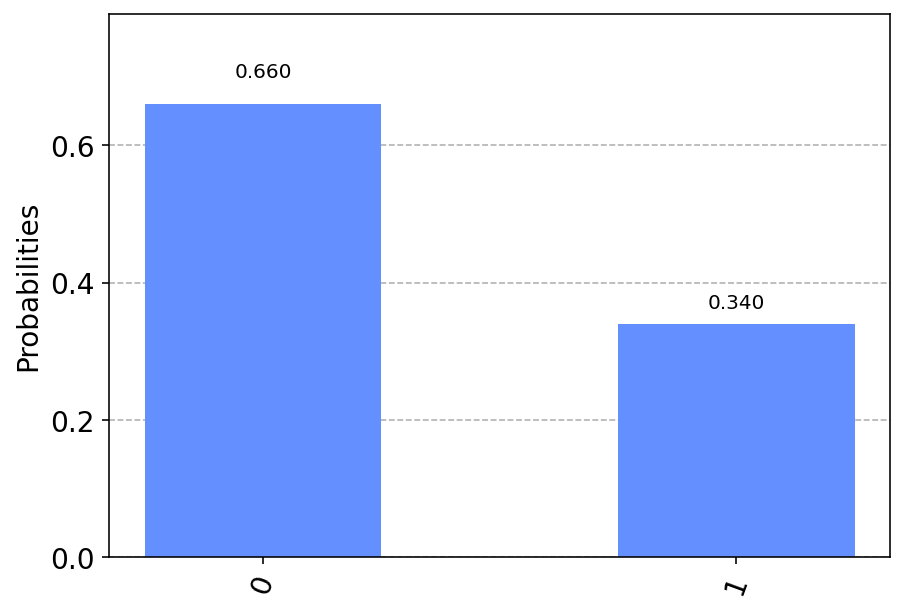

In [53]:
# Set qubit0 to p_child
qc.ry(prob_to_angle(p_child), 0)

# Set qubit1 to p_female
qc.ry(prob_to_angle(p_female), 1)

# set state |00> to conditional probability of male adults
qc.x(0)
qc.x(1)
ccry(qc,prob_to_angle(p_surv_m_a),0,1,2)
qc.x(0)
qc.x(1)

# set state |01> to conditional probability of male children
qc.x(0)
ccry(qc,prob_to_angle(p_surv_m_c),0,1,2)
qc.x(0)

# set state |10> to conditional probability of female adults
qc.x(1)
ccry(qc,prob_to_angle(p_surv_f_a),0,1,2)
qc.x(1)

# set state |11> to conditional probability of female children
ccry(qc,prob_to_angle(p_surv_f_c),0,1,2)

qc.measure(qr[2], cr[0])
results = execute(qc,Aer.get_backend('qasm_simulator'), shots=1000).result().get_counts()
plot_histogram(results)